# Aprendizaje Relacional - Dataset POLE
John David Urena Melendez
ing.jdum@gmail.com

Última actualización: 12/01/2024

In [45]:
# Importar las librerias necesarias para correr el proyecto
import constants # Paquete que contiene los queries
import utils # Paquete con funciones utilitarias
from SessionManager import SessionManager # Manejador de acceso a la base de datos de Neo4j
import pandas as pd
from itertools import product
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

Es importante leer el readme.md ya que, como la data se carga mediante queries a Neo4j, es necesario tener la instancia corriendo de forma local con el dataset cargado.

In [50]:
# Cargar Data
driver = SessionManager()
queries = constants.queries_dict
try:
    driver.execute(queries['create_social'])
except:
    print("Subgrafo ya existe")


Subgrafo ya existe


In [51]:
# Obtener medidas de centralidad
triangle_count = driver.bring_data(queries['triangle_count'])
betweeness = driver.bring_data(queries['betweeness'])
closeness = driver.bring_data(queries['closeness'])
degree = driver.bring_data(queries['degree'])
page_rank = driver.bring_data(queries['page_rank'])
clustering = driver.bring_data(queries['clustering'])
commited_crime = driver.bring_data(queries['commited_crime'])

In [52]:
# Crear un solo datagrame unido por el id para asegurarnos que cada dato corresponda con el mismo nodo
data = pd.merge(triangle_count, betweeness, on='id')
data = pd.merge(data, closeness, on='id')
data = pd.merge(data, degree, on='id')
data = pd.merge(data, page_rank, on='id')
data = pd.merge(data, clustering, on='id')
data = pd.merge(data, commited_crime, on='id')

In [53]:
# Obtener por separado cada medida de centralidad

# Target
y = list(data['committed_crime'])  # the value to predict is often called y
# Features
triangle_count = list(data['triangles'])
betweeness = list(data['betweeness'])
closeness = list(data['closeness'])
degree = list(data['degree'])
pagerank = list(data['pagerank'])
clustering = list(data['clustering'])
print(sum(y))
data


29


,id,triangles,betweeness,closeness,degree,pagerank,clustering,name,surname,committed_crime
0,838-45-9343,10,735,0.225380,7.0,1.540575,0.476190,Deborah,Ford,False
1,884-33-9676,9,726,0.221141,7.0,1.561524,0.428571,Phillip,Perry,False
2,245-63-7539,8,276,0.217613,6.0,1.336862,0.533333,Peter,Bryant,False
3,298-36-6290,7,1206,0.226880,7.0,1.637613,0.333333,Jonathan,Hunt,False
4,915-75-5600,7,2389,0.242705,8.0,1.766462,0.250000,Harry,Lopez,False
...,...,...,...,...,...,...,...,...,...,...
363,696-28-4220,0,340,0.198602,2.0,0.764593,0.000000,Linda,Boyd,False
364,563-60-8705,0,340,0.182842,2.0,0.782831,0.000000,Jessica,Foster,False
365,537-30-3032,0,0,0.160773,1.0,0.434735,0.000000,Melissa,Gibson,False
366,548-59-5017,0,179,0.191251,2.0,0.661950,0.000000,Kimberly,Alexander,False


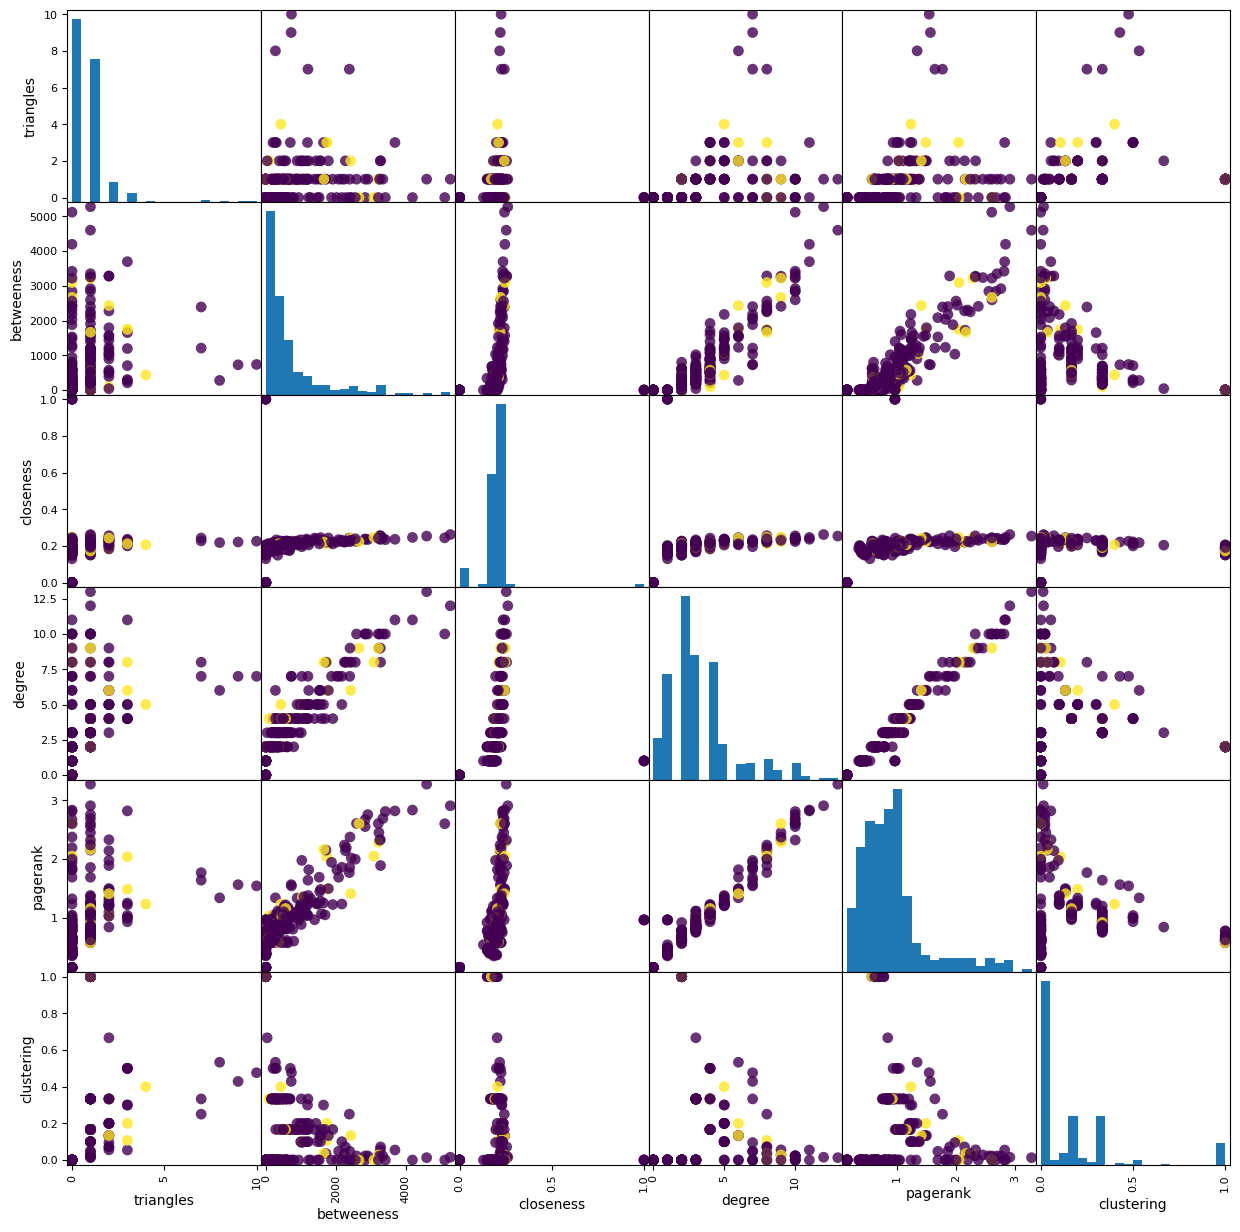

In [54]:
# Explore the data to get insights
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
# Convert y_encoded to a NumPy array
y_encoded = np.array(y_encoded)
numeric_data = data.select_dtypes(include=[np.number])

sp = pd.plotting.scatter_matrix(numeric_data, c=y_encoded, figsize=(15, 15), marker='o',
                                 hist_kwds={'bins': 20}, s=60, alpha=.8)

                        

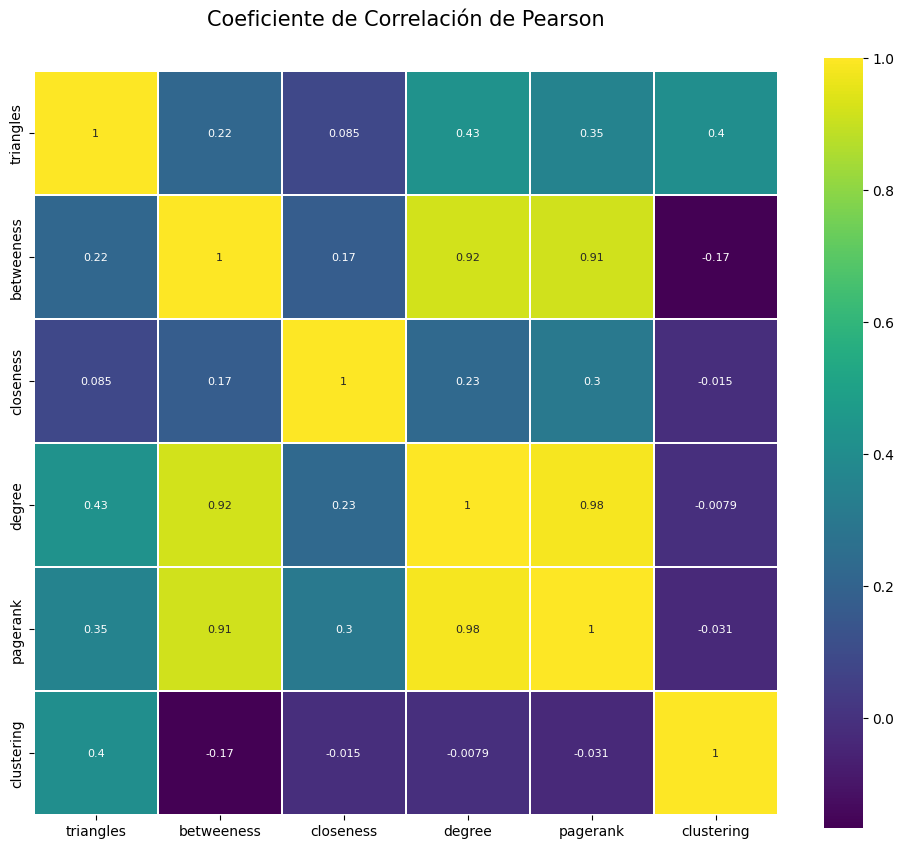

In [55]:
plt.figure(figsize=(12, 10))  

# Create the heatmap
title = 'Coeficiente de Correlación de Pearson'
sns.heatmap(numeric_data.astype(float).corr(), linewidths=0.1, vmax=1.0,
            square=True, cmap='viridis', linecolor='white', annot=True, annot_kws={"size": 8})  

plt.title(title, y=1.05, size=15)

# Show the plot
plt.show()

In [56]:
# Obtener un array con cada medida de centralidad y sus titulos esto sera de utilidad
# mas adelante cuando utilicemos la funcion para encontrar la mejor combinacion de features.
measures = np.array([triangle_count, betweeness, closeness, degree, pagerank, clustering]).T

centrality_measures = ['triangles', 'betweenness', 'closeness', 'degree', 'pagerank', 'clustering']
param_grid = list(product(*[[False, True] for _ in centrality_measures]))[1:]

In [57]:
# create test train split
X_train, X_test, y_train, y_test = train_test_split(measures, y, test_size=0.2, random_state=42)

In [ ]:
# La funcion find_best_param se encuentra en el paquete utils, basicamente prueba cada combinacion sin repeticion
# de las medidas de centralidad para tratar de encontrar la combinacion que nos da mejor resultado

### DESCOMENTAR LA SIGUIENTE LINEA SI QUIERE CORRER LA FUNCION, NOTA: TARDA MUCHO EN EJECUTARSE
# utils.find_best_params(param_grid, centrality_measures, X_train, y_train, X_test, y_test)

Para facilitar la lectura del documento, exporte los resultados a un csv y asi no se tiene que esperar a que el codigo termine de ejecutarse. En caso de que se quiera replicar con la propia data generada de correr el codigo encima, descomentar el codigo. Copiar lo que se imprima la consola en la variable de texto correspondiente en text_parser.py y correr la funcion result_to_csv

In [58]:
# Cargar los resultados de entrenar con las combinaciones de la medida de centralidad
df = pd.read_csv('centrality.csv')
df_sorted = df.sort_values(by='Test Set Accuracy', ascending=False)
df_sorted.head(5)

,n_estimators,min_samples_split,min_samples_leaf,max_depth,class_weight,Test Set Accuracy,Training Set Accuracy,Features
0,100,10,4,6,balanced,0.891892,0.962585,"['triangles', 'betweenness', 'closeness', 'pag..."
5,100,10,8,6,balanced,0.878378,0.880952,"['triangles', 'betweenness', 'closeness']"
7,100,10,4,7,balanced,0.878378,0.931973,"['betweenness', 'closeness', 'degree']"
6,100,10,6,6,balanced,0.878378,0.945578,"['betweenness', 'closeness', 'degree', 'pagera..."
1,100,5,8,6,balanced,0.878378,0.901361,"['betweenness', 'closeness']"


In [61]:
measures = np.array([triangle_count, betweeness, closeness, pagerank]).T

centrality_measures = ['triangle_count', 'betweeness', 'closeness', 'pagerank']

# create test train split
X_train, X_test, y_train, y_test = train_test_split(measures, y, test_size=0.2, random_state=42)

# Train tre
tree3_clf = RandomForestClassifier(n_estimators=100, min_samples_split=10, 
min_samples_leaf=4, max_depth=6, class_weight='balanced')
tree3_clf.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced', max_depth=6, min_samples_leaf=4,
                       min_samples_split=10)

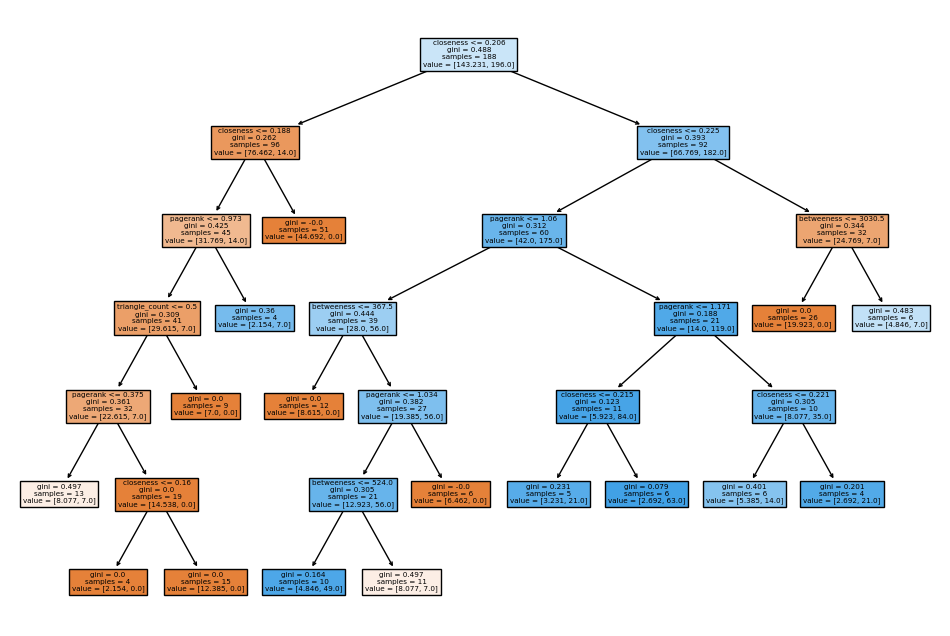

In [62]:
# Visualize a decision tree (the second tree)
plt.figure(figsize=(12, 8))
plot_tree(tree3_clf.estimators_[1], filled=True, feature_names=centrality_measures)
plt.show()

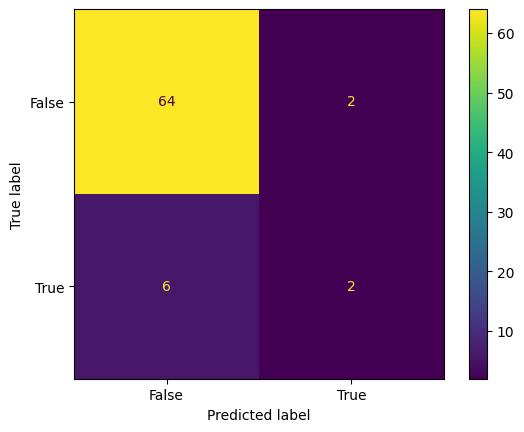

In [63]:
utils.plot_confusion_matrix(y_test, tree3_clf, X_test)

Estos son los 5 mejores resultados segun la precision en el cojunto de pruebas, vemos que al prediccion de los positivos no es muy precisa, esto es en gran parte debido a los pocos datos positivos que tenemos en el entrenamiento. Vamos a crear algunos parametros que puedan ayudar con la prediccion segun nuestro conocimiento del problema y vamos a evaluar si hay alguna mejora en nuestras predicciones.

In [64]:
# new features
length_to_criminal = driver.bring_data(queries['length_to_criminal'])
length_to_criminal.fillna(0, inplace=True)
known_criminals_3 = driver.bring_data(queries['known_criminals_3'])
lives_with_criminal = driver.bring_data(queries['lives_with_criminal'])

# new dataset
data = pd.merge(data, length_to_criminal, on='id')
data = pd.merge(data, known_criminals_3, on='id')
data = pd.merge(data, lives_with_criminal, on='id')

# new features
nearest_path = list(data['nearest_path'])
connected_criminals_count = list(data['connected_criminals_count'])
total_crimes_count = list(data['total_crimes_count'])
lives_with_criminal = list(data['lives_with_criminal'])


measures = np.array([triangle_count, betweeness, closeness, degree, pagerank,
                     clustering, nearest_path, connected_criminals_count, total_crimes_count, lives_with_criminal]).T

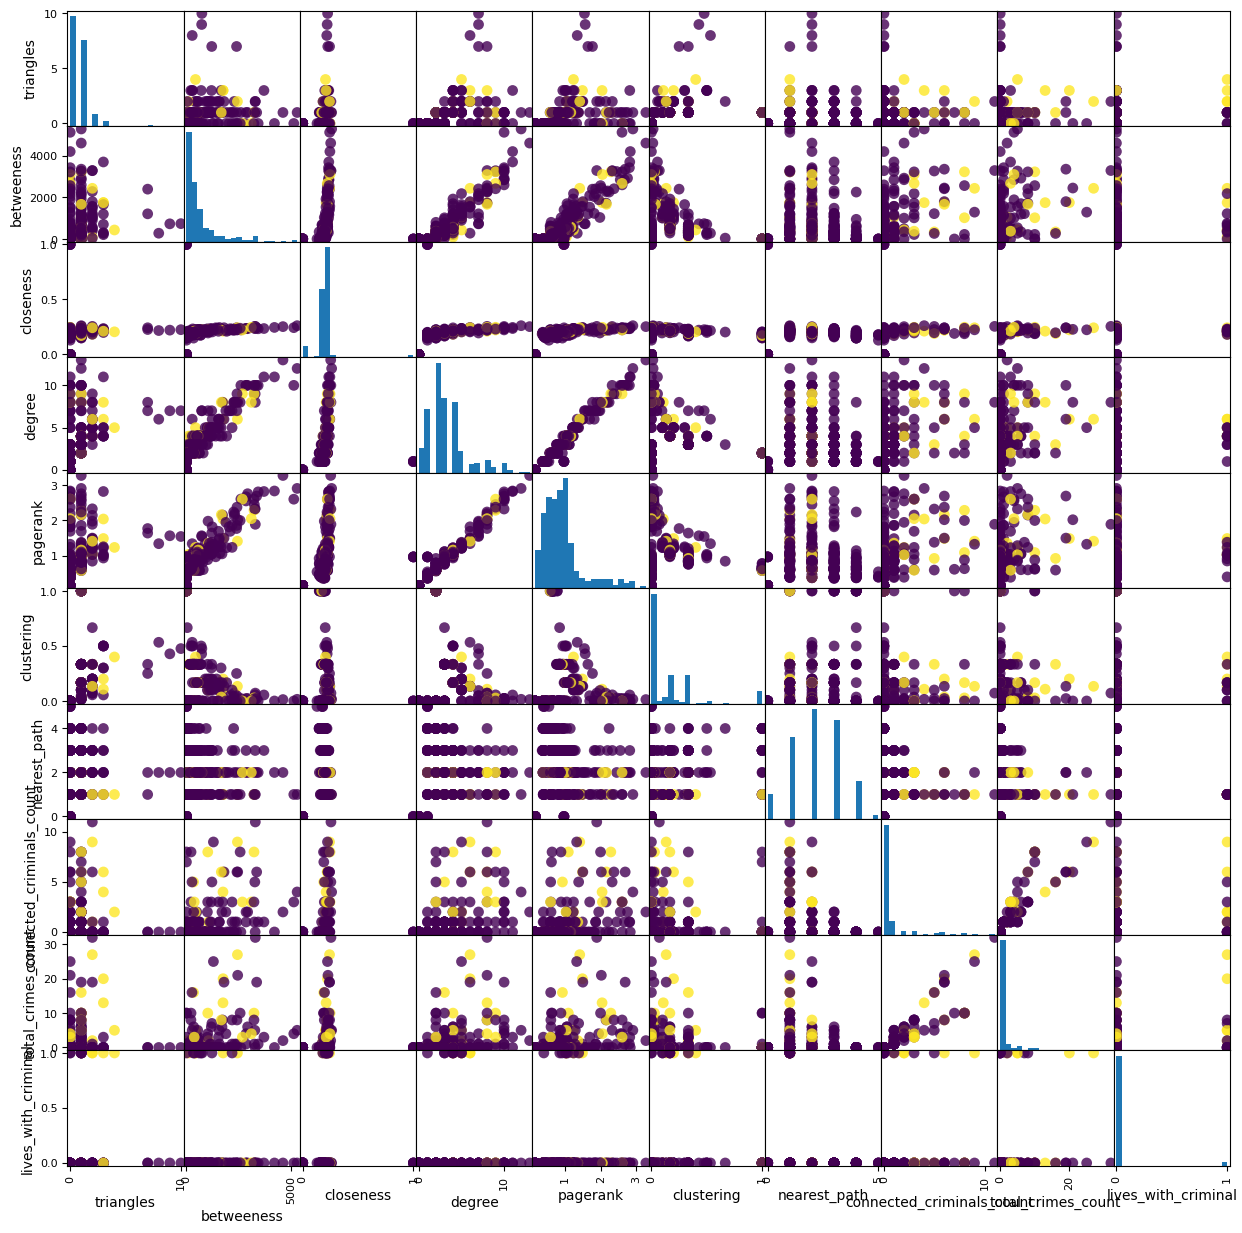

In [65]:
# Explore the data to get insights
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
# Convert y_encoded to a NumPy array
y_encoded = np.array(y_encoded)
numeric_data = data.select_dtypes(include=[np.number])

sp = pd.plotting.scatter_matrix(numeric_data, c=y_encoded, figsize=(15, 15), marker='o',
                                 hist_kwds={'bins': 20}, s=60, alpha=.8)

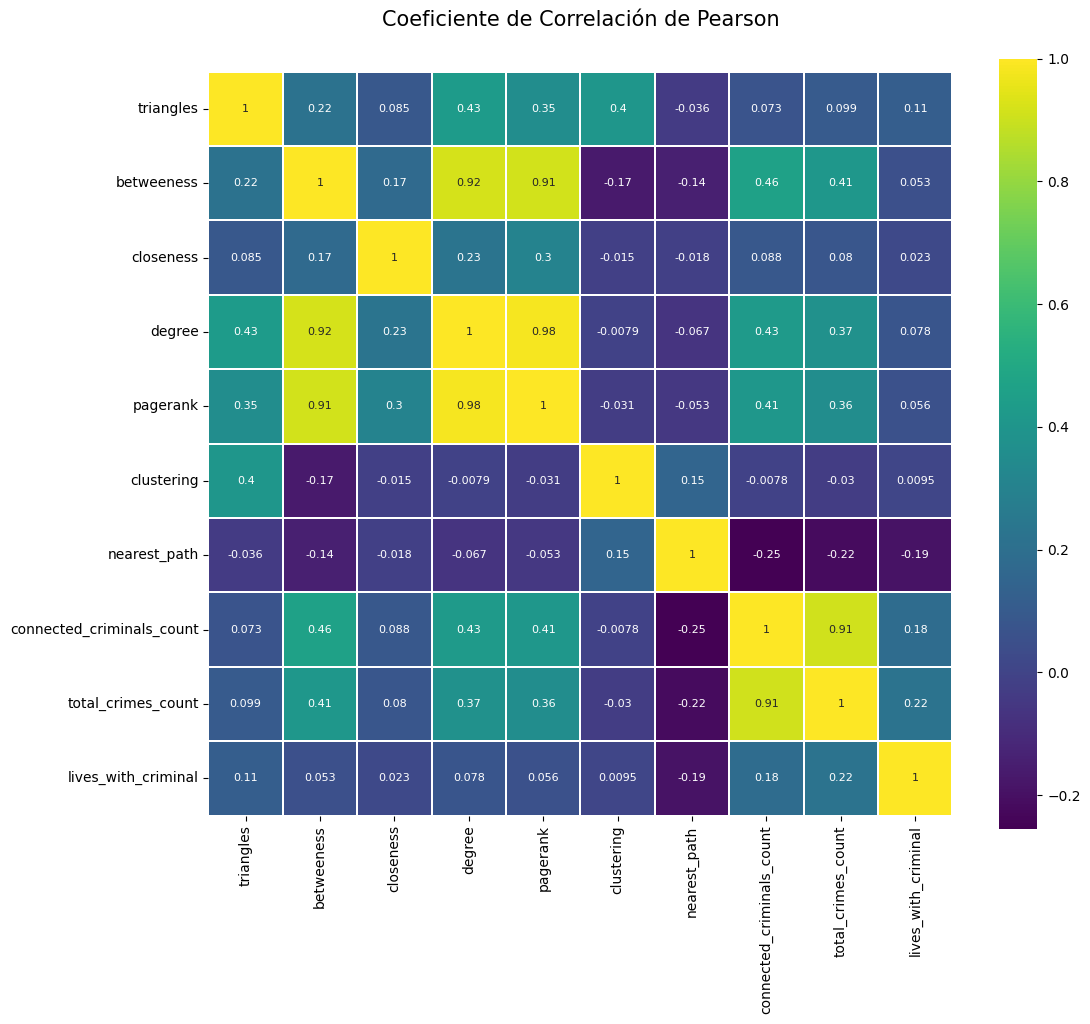

In [66]:
plt.figure(figsize=(12, 10))  

# Create the heatmap
title = 'Coeficiente de Correlación de Pearson'
sns.heatmap(numeric_data.astype(float).corr(), linewidths=0.1, vmax=1.0,
            square=True, cmap='viridis', linecolor='white', annot=True, annot_kws={"size": 8})  

plt.title(title, y=1.05, size=15)

# Show the plot
plt.show()

In [67]:
centrality_measures = ['triangles', 'betweenness', 'closeness', 'degree', 'pagerank',
                       'clustering', 'nearest_path', 'connected_criminals_count',
                       'total_crimes_count', 'lives_with_criminal']

param_grid = list(product(*[[False, True] for _ in centrality_measures]))[1:]

# create test train split
X_train, X_test, y_train, y_test = train_test_split(measures, y, test_size=0.2, random_state=42)

In [ ]:
### DESCOMENTAR LA SIGUIENTE LINEA SI QUIERE CORRER LA FUNCION, NOTA: TARDA MUCHO EN EJECUTARSE
# utils.find_best_params(param_grid, centrality_measures, X_train, y_train, X_test, y_test)

In [68]:
# Cargar los resultados de entrenar con las combinaciones de la medida de centralidad
df = pd.read_csv('problem_knowledge_features.csv')
df_sorted = df.sort_values(by='Test Set Accuracy', ascending=False)
df_sorted.head(5)

,n_estimators,min_samples_split,min_samples_leaf,max_depth,class_weight,Test Set Accuracy,Training Set Accuracy,Features
0,100,5,6,6,balanced,0.918919,0.880952,"['closeness', 'connected_criminals_count', 'li..."
2,100,5,6,6,balanced,0.905405,0.857143,"['pagerank', 'connected_criminals_count', 'liv..."
3,100,5,8,7,balanced,0.905405,0.894558,"['betweenness', 'pagerank', 'nearest_path', 'c..."
4,100,10,8,7,balanced,0.905405,0.877551,"['closeness', 'degree', 'connected_criminals_c..."
5,100,5,6,6,balanced,0.905405,0.925170,"['closeness', 'pagerank', 'connected_criminals..."


Logramos mejorar la precision en el set de pruebas aunque nuestra precision pero en el set de entrenamiento reducio, asi que en promedio no tuvimos ninguna mejora significativa. Hagamos una exploracion de los resultados para tratar de entender mejor que esta sucediendo.

In [69]:
measures = np.array([closeness, connected_criminals_count, lives_with_criminal]).T

centrality_measures = ['closeness', 'connected_criminals_count', 'lives_with_criminal']

# create test train split
X_train, X_test, y_train, y_test = train_test_split(measures, y, test_size=0.2, random_state=42)

# Train tre
tree3_clf = RandomForestClassifier(n_estimators=100, min_samples_split=5, 
min_samples_leaf=6, max_depth=6, class_weight='balanced')
tree3_clf.fit(X_train,y_train)

RandomForestClassifier(class_weight='balanced', max_depth=6, min_samples_leaf=6,
                       min_samples_split=5)

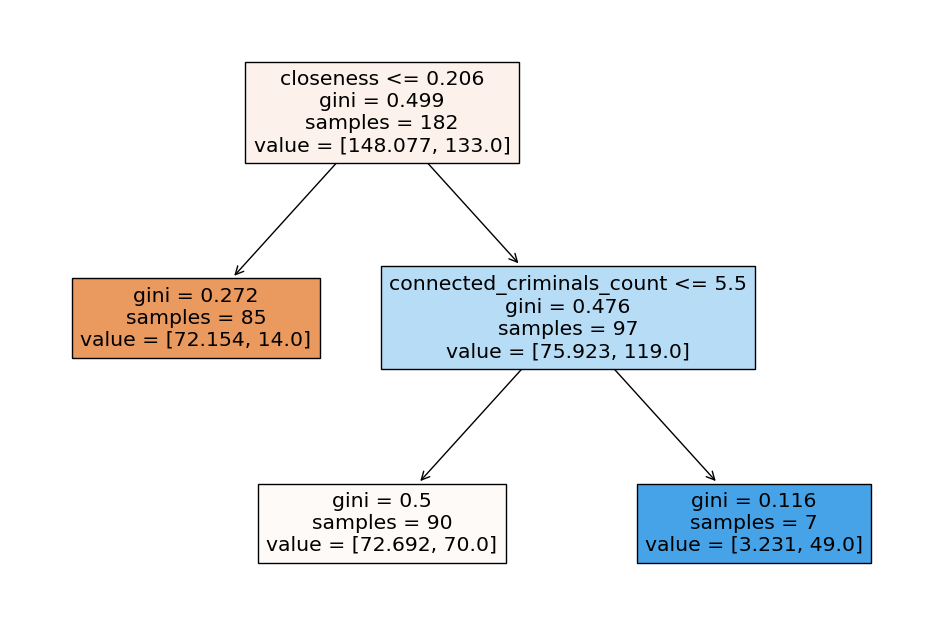

In [70]:
# Visualize a decision tree (the second tree)
plt.figure(figsize=(12, 8))
plot_tree(tree3_clf.estimators_[1], filled=True, feature_names=centrality_measures)
plt.show()

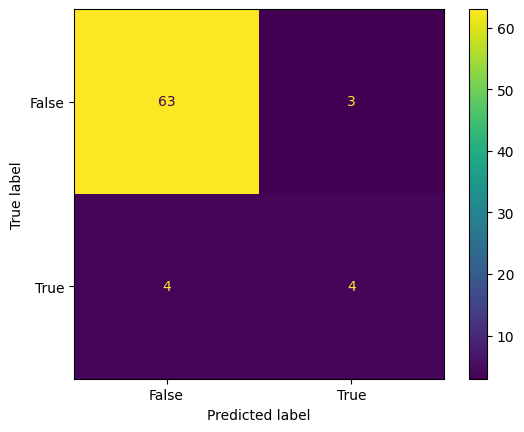

In [71]:
utils.plot_confusion_matrix(y_test, tree3_clf, X_test)

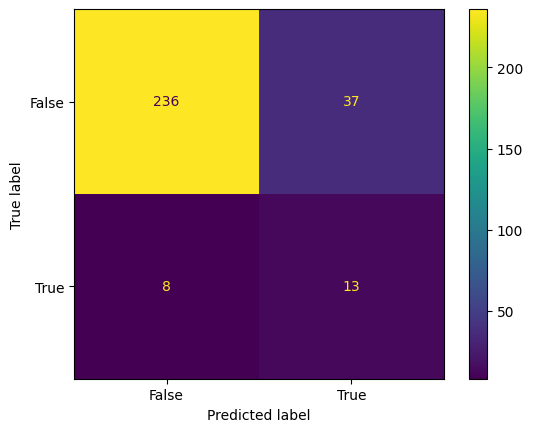

In [72]:
utils.plot_confusion_matrix(y_train, tree3_clf, X_train)

Al analizar la matriz de confusión, se hace evidente el desafío que presenta la limitada cantidad de datos positivos para obtener conclusiones sólidas. Con tan solo 6 ejemplos en nuestro conjunto de pruebas y 38 en el conjunto de entrenamiento, la generación de datos sintéticos podría considerarse como una opción, aunque actualmente está más allá del alcance de este proyecto. Es importante destacar que la matriz de confusión en el conjunto de entrenamiento revela un alto número de falsos positivos, una situación potencialmente peligrosa, especialmente en nuestro contexto de detección de crímenes.

### CODIGO UTILITARIO PARA GENERAR GRAFICOS UTILIZADOS EN LA MEMORIA

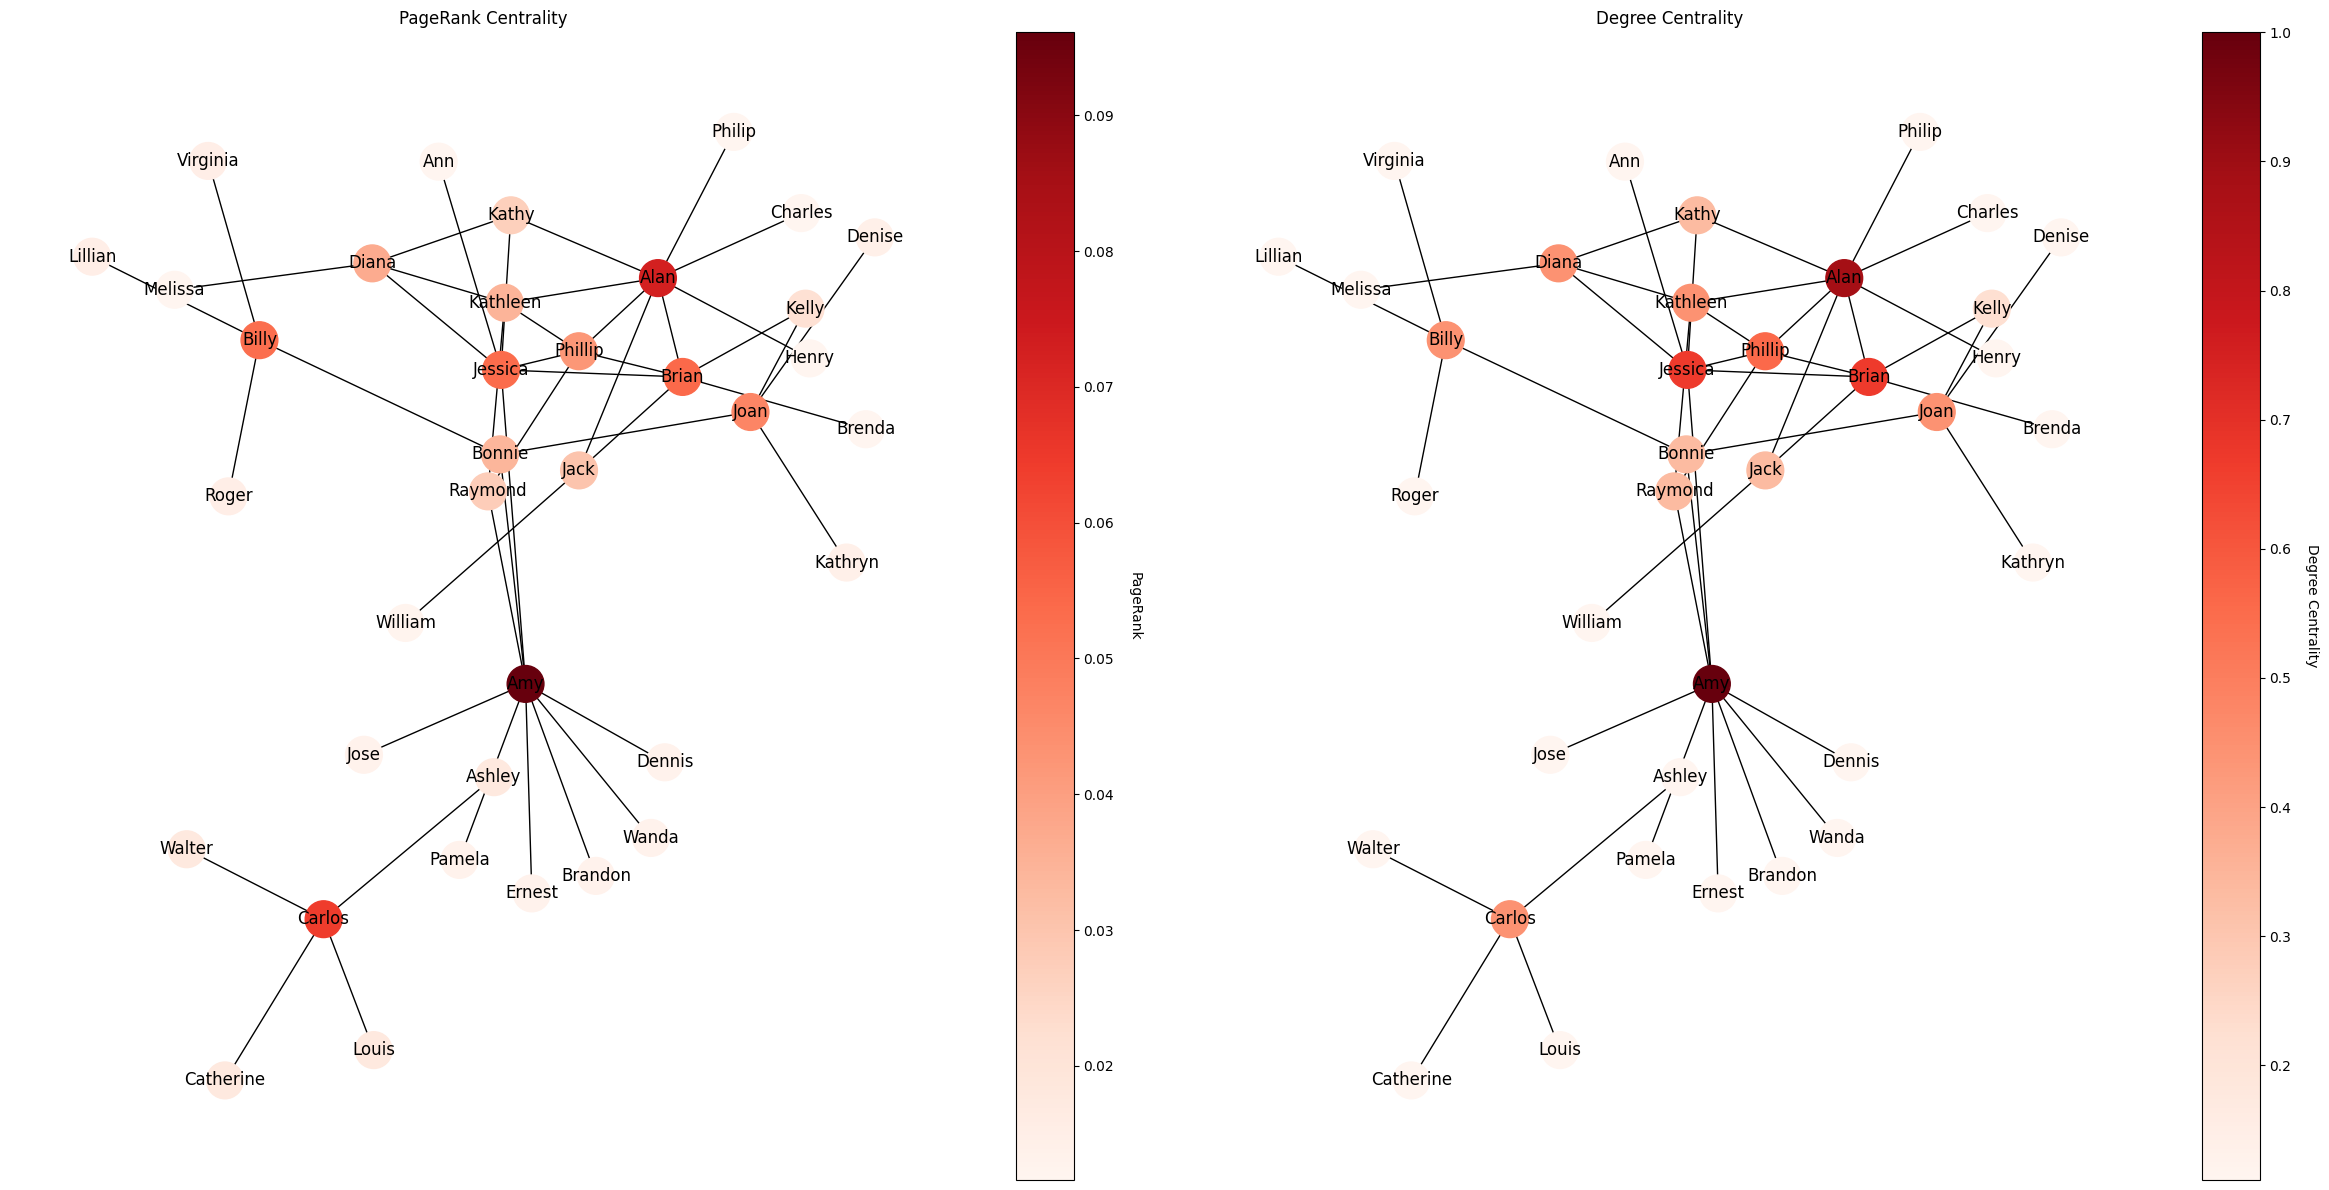

In [73]:
import networkx as nx
from matplotlib import pyplot as plt
from SessionManager import SessionManager

driver = SessionManager()


# Function to execute Cypher query and return results
def fetch_data():
    result = driver.execute("""
        MATCH (p:Person)-[:KNOWS*..1]-(cp:Person)-[:PARTY_TO]-(c:Crime) 
        WHERE c.type="Drugs" or c.type="Vehicle crime"
        RETURN p.name AS Person1, cp.name AS Person2
        """)
    return [(record["Person1"], record["Person2"]) for record in result]


# Fetch data
edges = fetch_data()

# Construct a graph
G = nx.Graph()
G.add_edges_from(edges)

# Calculate PageRank
page_rank = nx.pagerank(G)

# Calculate degree centrality
degree_centrality = nx.degree_centrality(G)
# Normalize degree centrality (optional, for better color mapping)
max_degree = max(degree_centrality.values())
degree_centrality_normalized = {k: v / max_degree for k, v in degree_centrality.items()}


# Increase the distance between nodes
pos = nx.spring_layout(G, k=0.40, seed=11)  # Experiment with the k value to find a suitable distance

# Create figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(24, 12))

# Plot for PageRank
sc1 = nx.draw_networkx_nodes(G, pos, node_size=700, ax=axes[0],
                             node_color=list(page_rank.values()), cmap=plt.cm.Reds)
nx.draw_networkx_edges(G, pos, ax=axes[0])
nx.draw_networkx_labels(G, pos, font_size=12, ax=axes[0])
axes[0].set_title("PageRank Centrality")
axes[0].axis("off")

# Plot for Degree Centrality
sc2 = nx.draw_networkx_nodes(G, pos, node_size=700, ax=axes[1],
                             node_color=list(degree_centrality_normalized.values()), cmap=plt.cm.Reds)
nx.draw_networkx_edges(G, pos, ax=axes[1])
nx.draw_networkx_labels(G, pos, font_size=12, ax=axes[1])
axes[1].set_title("Degree Centrality")
axes[1].axis("off")

# Colorbars
plt.colorbar(sc1, ax=axes[0]).set_label('PageRank', rotation=270, labelpad=20)
plt.colorbar(sc2, ax=axes[1]).set_label('Degree Centrality', rotation=270, labelpad=20)

plt.tight_layout()
plt.show()